<a href="https://colab.research.google.com/github/sebastian-dv/CSE-151A-Project/blob/main/Model%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 2 - Neural Network


In [ ]:
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


In [ ]:
!pip install scikeras

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import keras_tuner
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from scikeras.wrappers import KerasClassifier
from sklearn import datasets
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

In [ ]:
df = pd.read_csv('https://archive.ics.uci.edu/static/public/880/data.csv')

df = df[['age','sex','death','dzgroup','scoma','race','sps','aps','diabetes','dementia','meanbp','wblc','hrt','resp','temp','pafi','alb','bili','crea','sod','ph']]

## Initial Preprocessing

In [ ]:
# one hot encoding race
ohe = pd.get_dummies(df[['race']])
df = df.drop(['race'], axis = 1)
df = pd.concat([df, ohe], axis = 1)

# dropping nan values
df = df.dropna(axis = 0, how = 'any')

# encoding sex
df['sex'].replace('female', 0, inplace=True)
df['sex'].replace('male', 1, inplace=True)

# one hot encoding dzgroup
ohe = pd.get_dummies(df[['dzgroup']])
df = df.drop(['dzgroup'], axis = 1)

X = df.copy()
y = ohe.copy()
df = pd.concat([df, ohe], axis = 1)

# scaling data
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

## Building the base model

In [ ]:
def buildmodel():
    model = Sequential([
        Dense(units = 72, activation = 'tanh', input_dim = 24),
        Dense(units = 42, activation = 'tanh'),
        Dense(units = 42, activation = 'tanh'),
        Dense(units = 42, activation = 'tanh'),
        Dense(units = 8, activation = 'softmax')
    ])
    model.compile(optimizer ='SGD', loss='categorical_crossentropy')
    return(model)

In [ ]:
classifier = buildmodel()
history = classifier.fit(X_train.astype(float), y_train, batch_size = 20, validation_split=0.1, epochs = 100, verbose = 0)
yhat_test = classifier.predict(X_test.astype(float))

24/24 [==============================] - 0s 1ms/step


In [ ]:
y_label = y_test.to_numpy()
actual = np.argmax(y_label, axis=1)
pred = np.argmax(yhat_test, axis=1)
print(classification_report(actual,pred))

              precision    recall  f1-score   support

           0       0.59      0.84      0.69       344
           1       0.47      0.26      0.34       103
           2       0.44      0.39      0.42        84
           3       0.50      0.10      0.16        41
           4       0.00      0.00      0.00        16
           5       0.69      0.62      0.65        65
           6       0.33      0.43      0.38        46
           7       0.50      0.10      0.17        69

    accuracy                           0.55       768
   macro avg       0.44      0.34      0.35       768
weighted avg       0.52      0.55      0.50       768



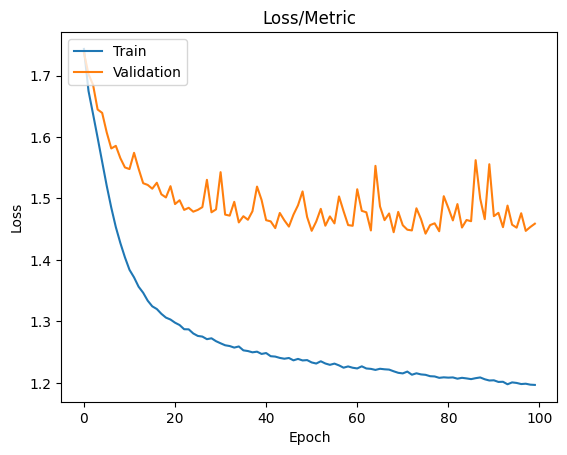

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss/Metric')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## K-Fold Cross-Validation

In [ ]:
def buildmodel():
    model = Sequential([
      Dense(units = 72, activation = 'tanh', input_dim = 24),
        Dense(units = 42, activation = 'tanh'),
        Dense(units = 42, activation = 'tanh'),
        Dense(units = 42, activation = 'tanh'),
        Dense(units = 8, activation = 'softmax')
    ])
    model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['mse','accuracy'])
    return(model)

#epochs are the number of iterative training steps we do on the entire dataset, and each iteration is a step. batch_size is the number of datapoints we select per batch. total obs = batch_size * batches
estimator = KerasClassifier(model=buildmodel, epochs=50, batch_size=20, verbose=0) # before submitting please set verbose = 0, and rerun. If not grading will be no bueno!
kfold = RepeatedKFold(n_splits = 10, n_repeats = 5)
results = cross_val_score(estimator, X_train, y_train, cv=kfold, n_jobs = 1,scoring = 'accuracy')

In [ ]:
avg_acc = results.mean()
avg_acc

0.5262466686408055

## Hyperparameter Tuning

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

In [ ]:
#build the hyperparameter tuning model with tuning the units, activation function, and learning rates
def build_model(hp):
    model = keras.Sequential()
    activation = hp.Choice("activation", ['relu', 'sigmoid', 'tanh', 'softmax', 'linear', 'leaky_relu', 'mish'])
    # input layer
    model.add(
        layers.Dense(units = hp.Int("units", min_value = 18, max_value = 180, step = 20),
              activation = activation,
              input_dim = X.shape[1]
        )
    )
    # hidden layers
    for i in range(3):
      model.add(
          layers.Dense(
              units = hp.Int("units", min_value = 12, max_value = 180, step = 20),
              activation = activation,
          )
      )
    # output layer
    model.add(
          layers.Dense(
              units = 8,
              activation = 'softmax'
          )
      )
    loss = hp.Choice("loss", values = ["categorical_crossentropy", "mse", "binary_crossentropy"])
    learning_rate = hp.Float("lr", min_value = 0.001, max_value = 0.1, step = 0.01)
    optimizer = hp.Choice("optimizer", values = ["sgd", "adam", "rmsprop"])
    if optimizer == "sgd":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "adam":
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == "rmsprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(
        optimizer = optimizer,
        loss = loss,
        metrics = ["accuracy"],
    )
    return model


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 1)

In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=10,
    overwrite=True,
    directory="my_dir",
    project_name="hypertune",
)
tuner.search(X_train, y_train, epochs=50, validation_split = 0.2, callbacks = [early_stopping], verbose = 0)

In [ ]:
tuner.results_summary(num_trials=1)

Results summary
Results in my_dir/hypertune
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 02 summary
Hyperparameters:
activation: linear
units: 98
loss: categorical_crossentropy
lr: 0.061
optimizer: sgd
Score: 0.560490071773529


18/18 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.58      0.82      0.68       247
           1       0.55      0.33      0.41        85
           2       0.29      0.54      0.37        59
           3       0.50      0.02      0.04        45
           4       0.00      0.00      0.00        19
           5       0.70      0.47      0.57        40
           6       0.38      0.22      0.28        36
           7       0.56      0.20      0.30        45

    accuracy                           0.52       576
   macro avg       0.45      0.33      0.33       576
weighted avg       0.52      0.52      0.47       576



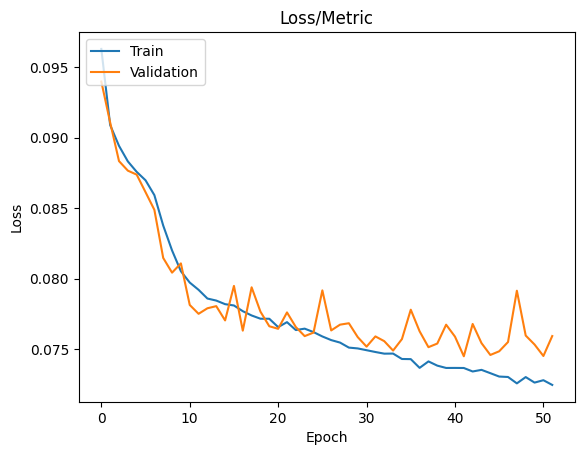

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

history = model.fit(X_train.astype(float), y_train, epochs=100, verbose = 0, callbacks = [early_stopping], validation_split = 0.2)

y_label = y_test.to_numpy()
yhat_test = model.predict(X_test.astype(float))
actual = np.argmax(y_label, axis=1)
pred = np.argmax(yhat_test, axis=1)

print(classification_report(actual,pred))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss/Metric')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Oversampling

In [ ]:
myle=LabelEncoder()
df = pd.read_csv('https://archive.ics.uci.edu/static/public/880/data.csv')

df = df[['age','sex','death','dzgroup','scoma','race','sps','aps','diabetes','dementia','meanbp','wblc','hrt','resp','temp','pafi','alb','bili','crea','sod','ph']]
# label encoding race
df['race'] = myle.fit_transform(df['race'])
# dropping nan values
df = df.dropna(axis = 0, how = 'any')

# encoding sex
df['sex'].replace('female', 0, inplace=True)
df['sex'].replace('male', 1, inplace=True)
print(df['dzgroup'].value_counts())
y = df['dzgroup']
X = df.drop(columns = 'dzgroup')

# scaling data
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

ARF/MOSF w/Sepsis    1725
CHF                   473
COPD                  447
MOSF w/Malig          338
Coma                  265
Cirrhosis             248
Lung Cancer           246
Colon Cancer           98
Name: dzgroup, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)

In [ ]:
smote = SMOTE(random_state = 21)
X_train_resample, y_train_resample = smote.fit_resample(X_train, y_train)

In [ ]:
ohe = OneHotEncoder()
y_train_encoded = ohe.fit_transform(pd.DataFrame(y_train_resample)).todense()
ohe = OneHotEncoder()
y_test_encoded = ohe.fit_transform(pd.DataFrame(y_test)).todense()

In [ ]:
X_train_resample, X_val, y_train_resample, y_val = train_test_split(X_train_resample, y_train_encoded, random_state = 21, test_size = 0.1)

In [ ]:
def buildmodel():
    model = Sequential([
        Dense(units = 72, activation = 'tanh', input_dim = 20),
        Dense(units = 42, activation = 'tanh'),
        Dense(units = 42, activation = 'tanh'),
        Dense(units = 42, activation = 'tanh'),
        Dense(units = 8, activation = 'softmax')
    ])
    model.compile(optimizer ='SGD', loss='categorical_crossentropy', metrics = ['accuracy'])
    return(model)

In [ ]:
classifier = buildmodel()
history = classifier.fit(X_train_resample,y_train_resample, batch_size = 20, epochs = 100, verbose = 0, validation_data=(X_val, y_val))
yhat_test = classifier.predict(X_test)

24/24 [==============================] - 0s 1ms/step


In [ ]:
actual_pred = []
for i in yhat_test:
  index = np.argmax(i)
  actual_pred.append(index)

In [ ]:
ground_truth = []
for i in y_test_encoded:
  index = np.argmax(i)
  ground_truth.append(index)

In [ ]:
print(classification_report(ground_truth,actual_pred))

              precision    recall  f1-score   support

           0       0.75      0.26      0.38       333
           1       0.41      0.44      0.42        96
           2       0.33      0.24      0.28        83
           3       0.26      0.59      0.36        49
           4       0.02      0.06      0.03        18
           5       0.57      0.73      0.64        77
           6       0.28      0.40      0.33        42
           7       0.22      0.56      0.31        70

    accuracy                           0.38       768
   macro avg       0.36      0.41      0.35       768
weighted avg       0.52      0.38      0.38       768



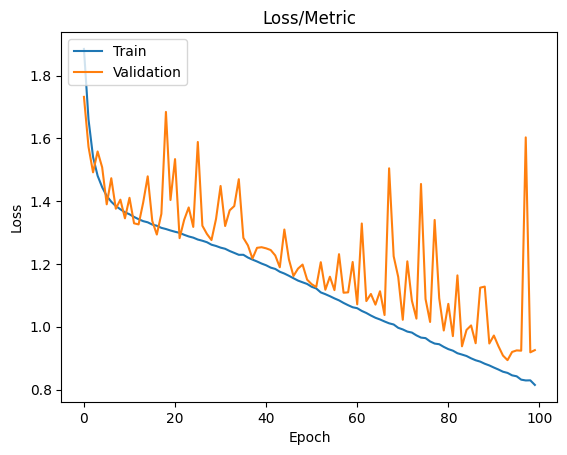

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss/Metric')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()